## Import Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
from matplotlib.pyplot import figure

## Read Image

In [3]:
def plotImage(img):
    figure(figsize=(14, 12), dpi=80)
    plt.imshow(img, cmap='gray')
    plt.show()

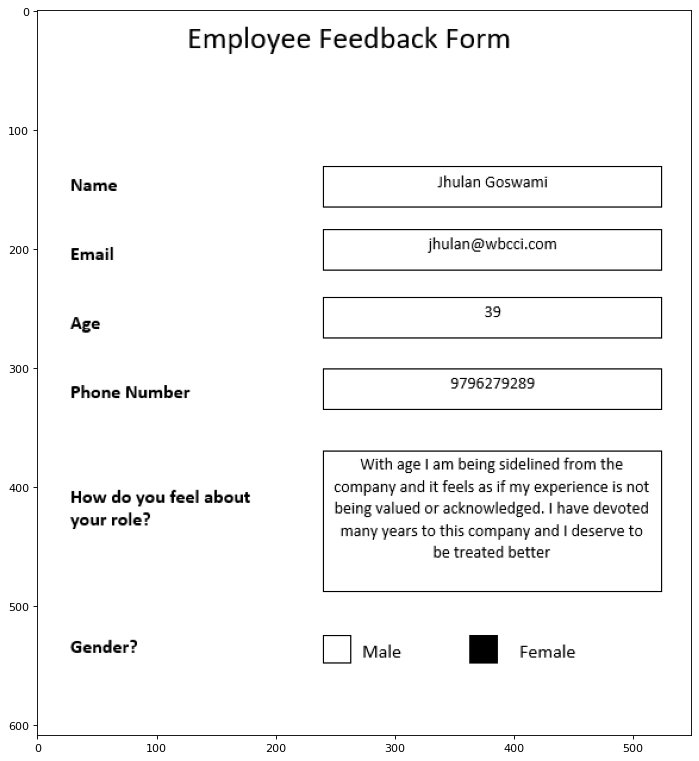

In [116]:
# read the image
img_path = 'images\\emp_3.png'
img = cv2.imread(img_path ,0)

#Plotting the image to see the output
plotImage(img)

## Image Preprocessing

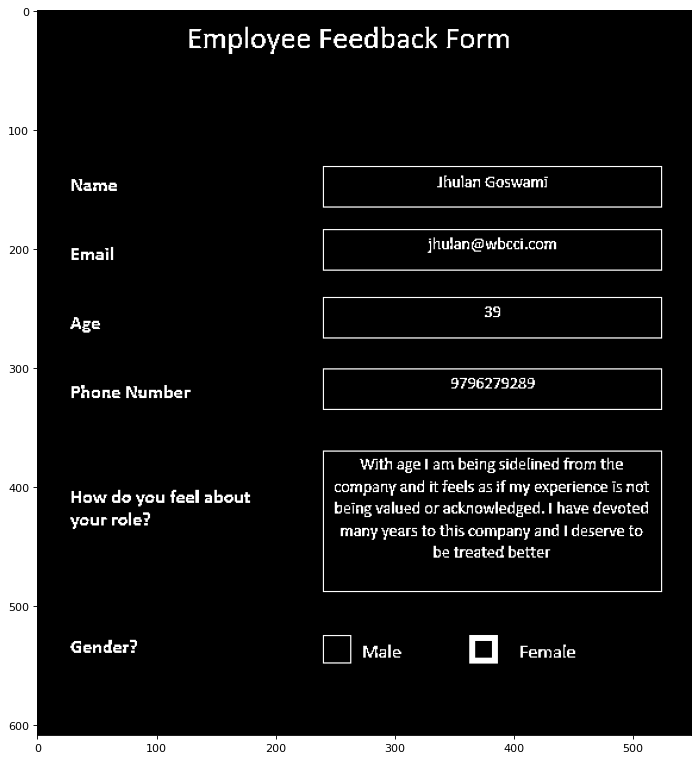

In [117]:
#thresholding the image to a binary image
img_bin = cv2.adaptiveThreshold(img,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

#inverting the image 
img_bin = 255 - img_bin

#Plotting the image to see the output
plotImage(img_bin)

## Define Kernels

In [120]:
# countcol(width) of kernel as 100th of total width
hor_kernel_len = np.array(img).shape[1] // 75
ver_kernel_len = np.array(img).shape[0] // 75

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, ver_kernel_len))

# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (hor_kernel_len, 1))

# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

print(ver_kernel)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [118]:
# # countcol(width) of kernel as 100th of total width
# kernel_len2 = np.array(img).shape[1] // 50

# # Defining a vertical kernel to detect all vertical lines of image 
# ver_kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len2))

# # Defining a horizontal kernel to detect all horizontal lines of image
# hor_kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len2, 1))

# # A kernel of 2x2
# kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

## Plot vertical lines in the image

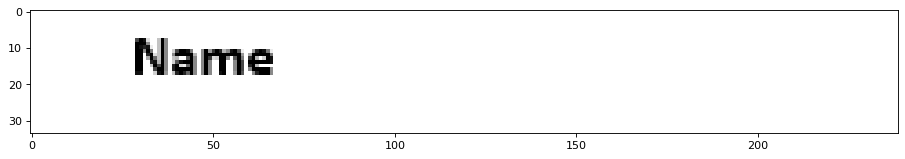

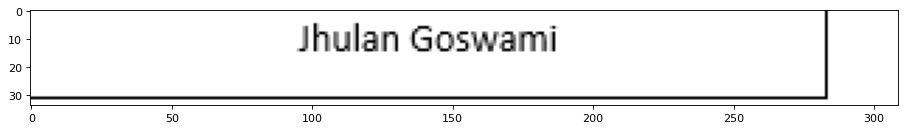

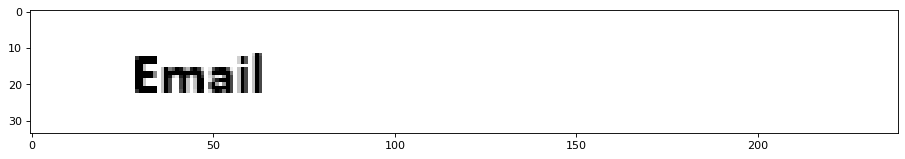

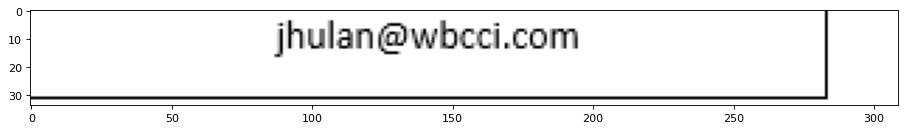

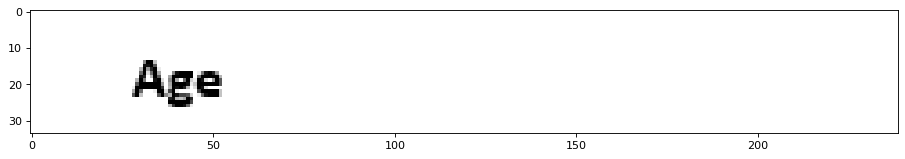

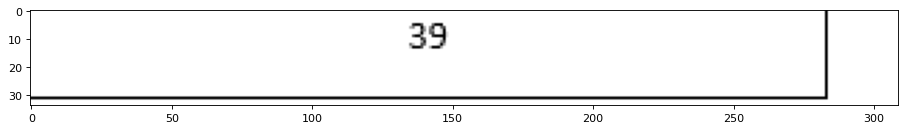

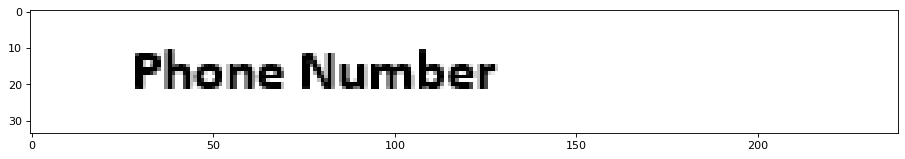

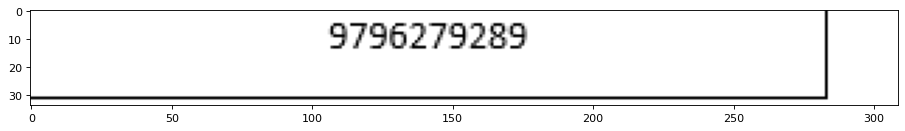

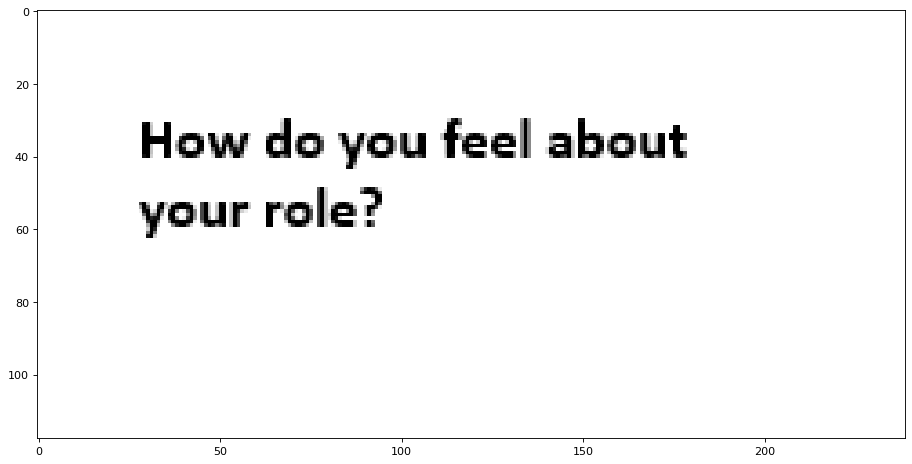

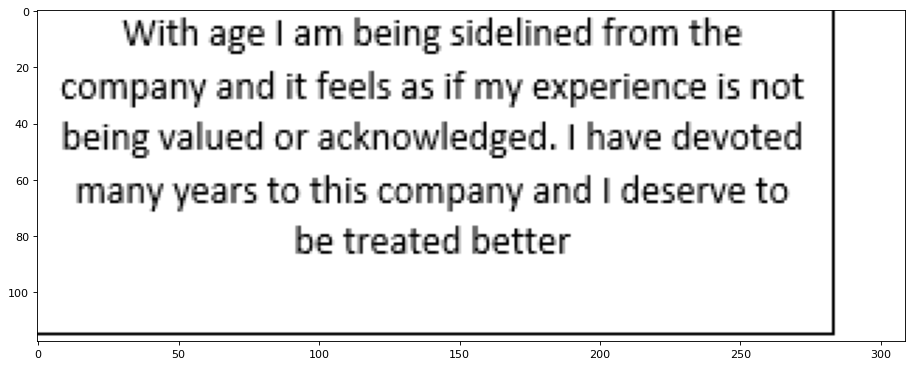

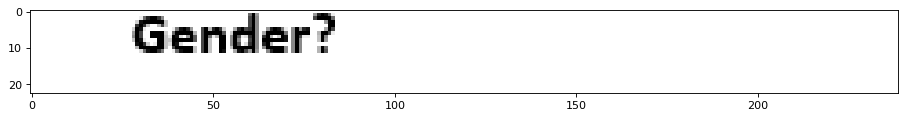

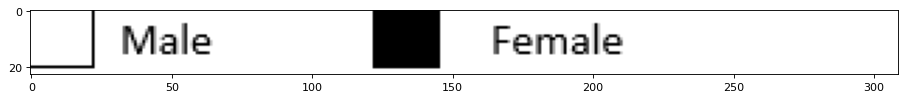

In [119]:
#Use vertical kernel to detect and save the vertical lines in a jpg
image_vertical_lines = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_vertical_lines, ver_kernel, iterations=3)


#Plot the generated image
# plotImage(vertical_lines)
arr = np.array(vertical_lines)


MAX = 255
i = 0
while i < len(arr):
    for j in range(len(arr[i])):
        if arr[i][j] == MAX:
            start, end = i, 0
            while arr[i][j] == MAX:
                i += 1
            end = i - 1
            x1, y1 = 0, start
            x2, y2 = img.shape[1], end
            temp_img1 = img[y1:y2, x1:j-1]
            temp_img2 = img[y1:y2, j+1:x2]
            plotImage(temp_img1)
            plotImage(temp_img2)

            # key = pytesseract.image_to_string(temp_img1)
            # value = pytesseract.image_to_string(temp_img2).replace("|", "I")
            # print(key, value)
            break
    i += 1


## Plot horizontal lines in the image

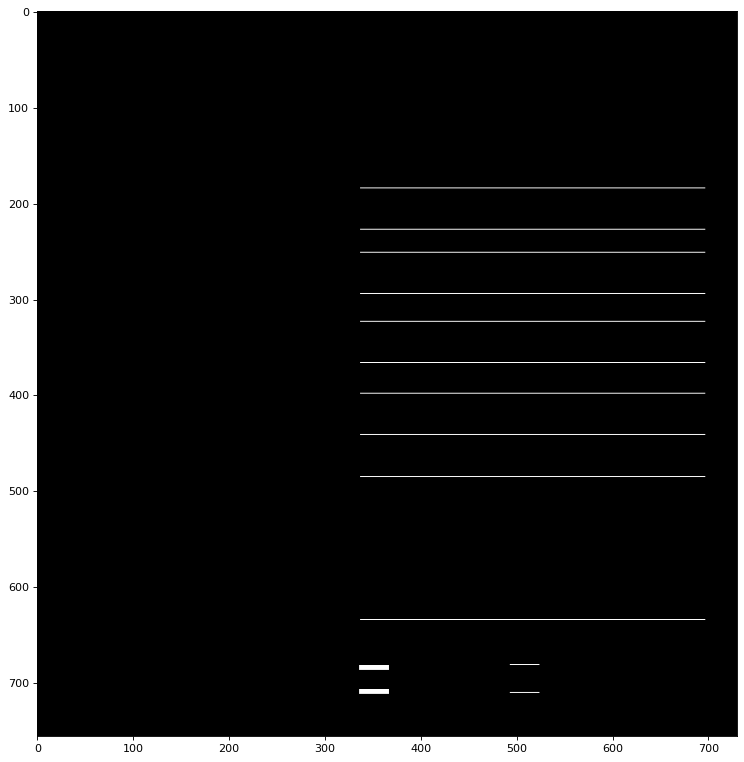

In [69]:
#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_horizontal_lines = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_horizontal_lines, hor_kernel, iterations=3)


#Plot the generated image
plotImage(horizontal_lines)

## Combine horizontal and vertical lines

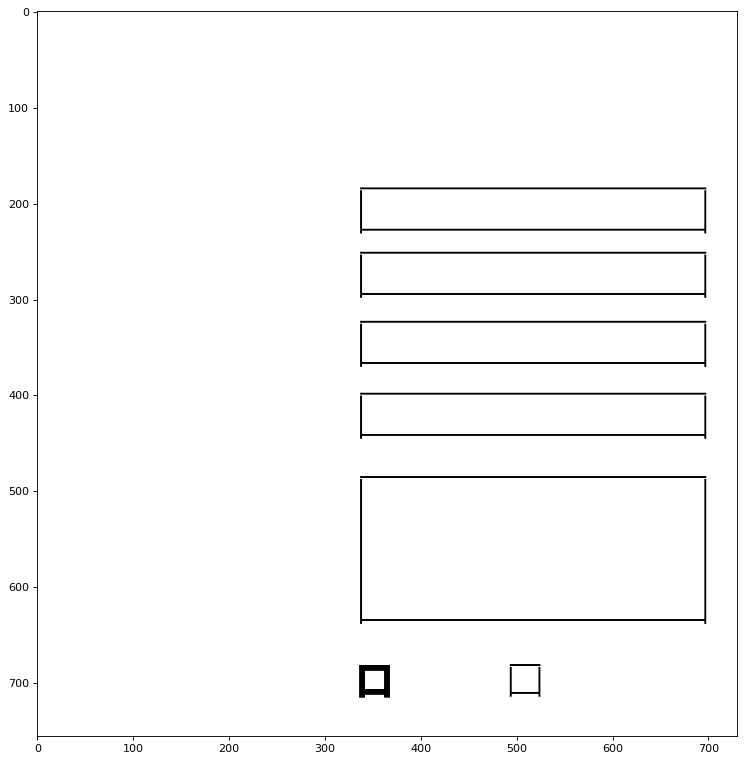

In [70]:
# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=1)
thresh, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

bitxor = cv2.bitwise_xor(img, img_vh)
bitnot = cv2.bitwise_not(bitxor)

#Plotting the generated image
plotImage(img_vh)

## Detect and sort contours

In [71]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contour_image = cv2.drawContours(img, contours, -1, (0,255,0), 3)
# plotImage(contour_image)

def sort_contours(cnts, method="left-to-right"):

    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")
print(len(contours))

15


## Create boxes in the image

In [72]:
#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

print(heights)

#Get mean of heights
mean = np.mean(heights)
print(mean)

[756, 4, 47, 4, 47, 4, 47, 4, 47, 4, 153, 4, 36, 33, 19]
80.6


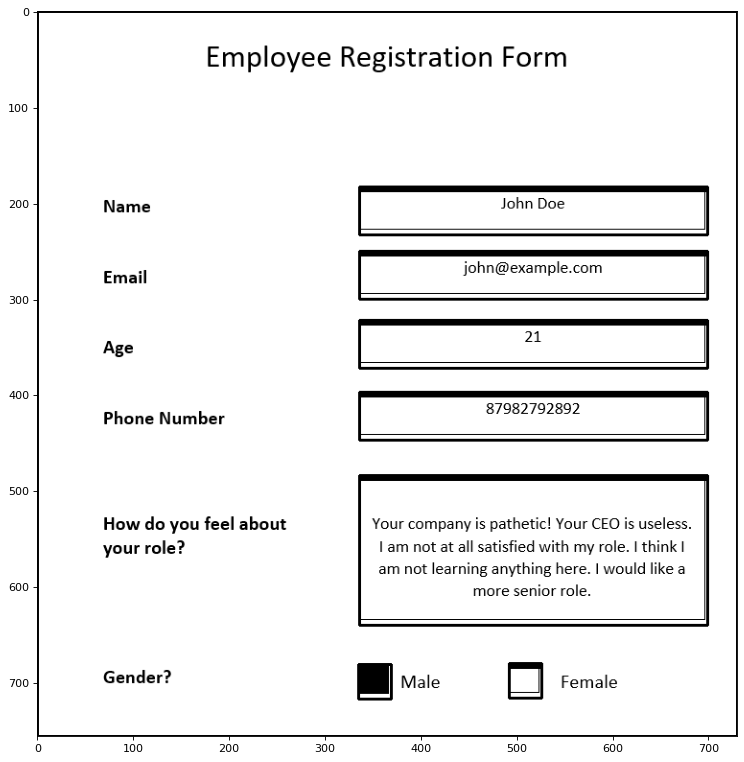

In [78]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if h < 10:
        continue
    # if (w < 1000 and h < 1000):
    image = cv2.rectangle(img,(x, y), (x + w, y + h), (0, 255, 0), 2)
    box.append([x, y, w, h])
    
plotImage(image)


In [79]:
#Creating two lists to define row and column in which cell is located
row = []
column = []
j = 0

#Sorting the boxes to their respective row and column
for i in range(len(box)):    
        
    if(i == 0):
        column.append(box[i])
        previous = box[i]    
    
    else:
        if(box[i][1] <= previous[1] + mean / 2):
            column.append(box[i])
            previous = box[i]            
            
            if(i == len(box) - 1):
                row.append(column)        
            
        else:
            row.append(column)
            column = []
            previous = box[i]
            column.append(box[i])

In [80]:
# Calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    currCol = len(row[i])
    if currCol > countcol:
        countcol = currCol

print(countcol)

3


In [81]:
# Retrieving the center of each column
center = [int(row[i][j][0] + row[i][j][2] / 2) for j in range(len(row[i])) if row[0]]

center = np.array(center)
center.sort()

# Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis = []
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center - (row[i][j][0] + row[i][j][2] / 4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

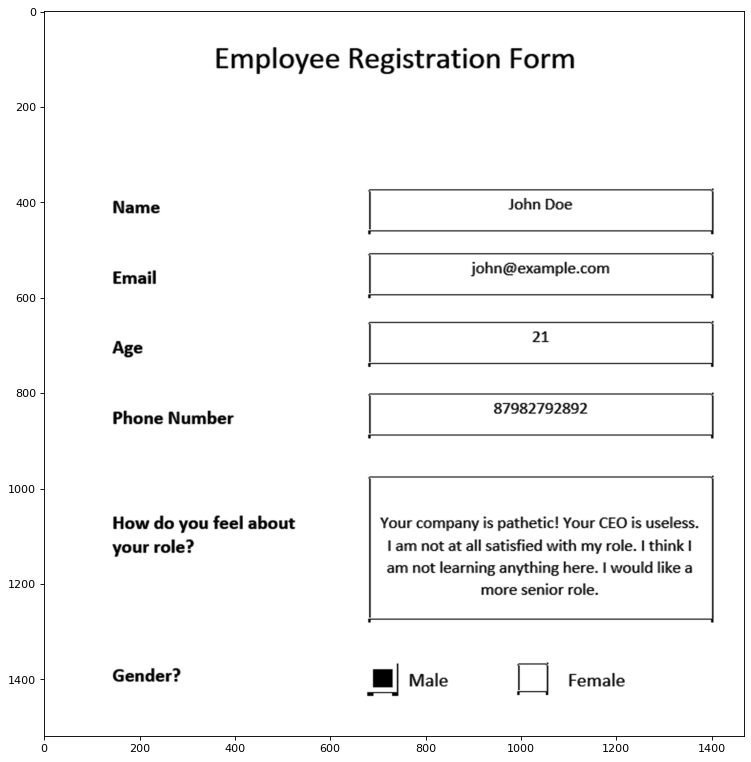

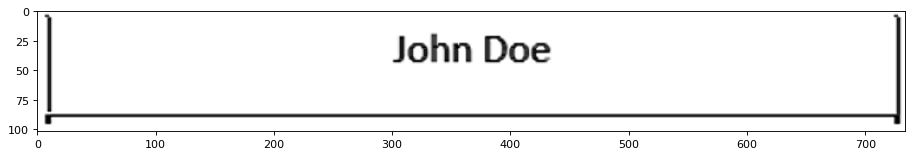

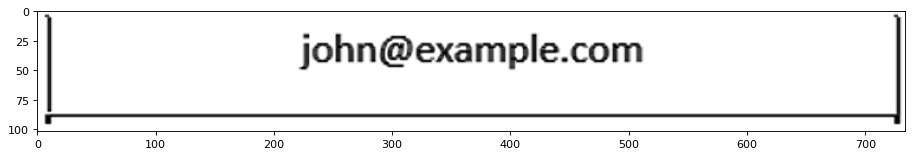

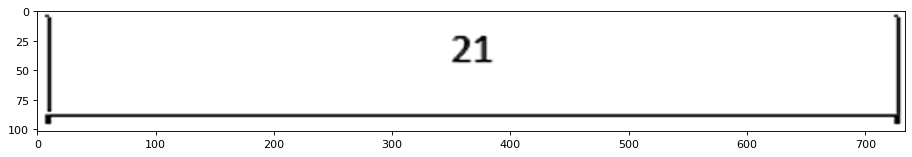

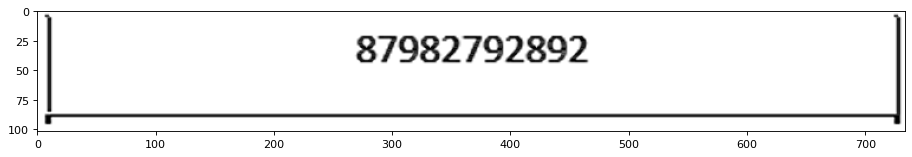

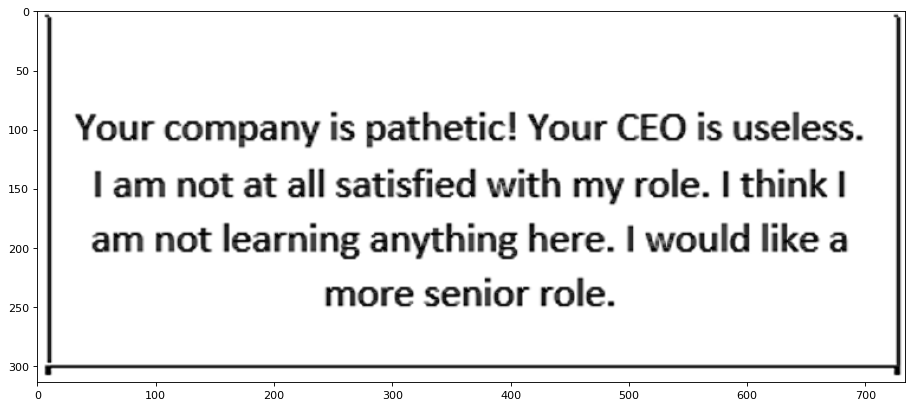

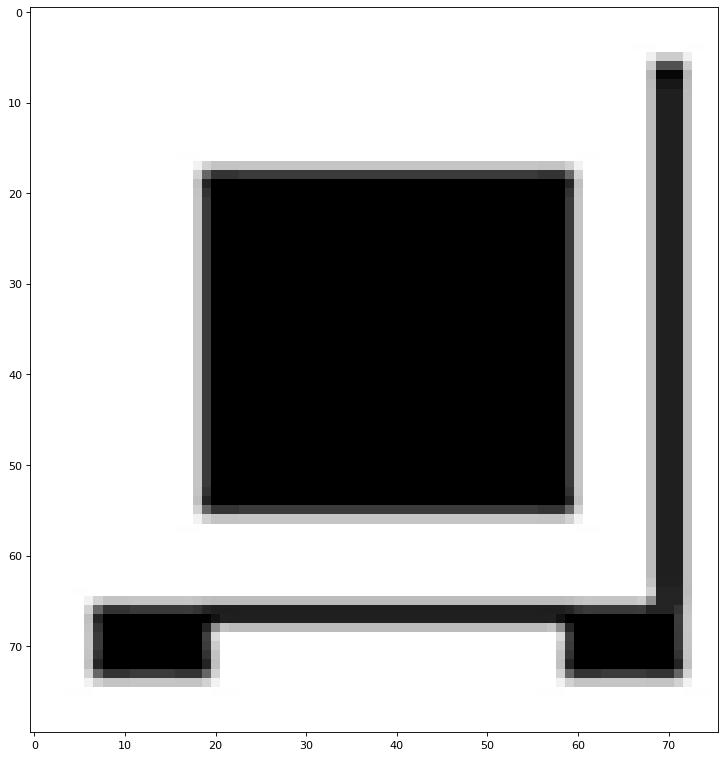

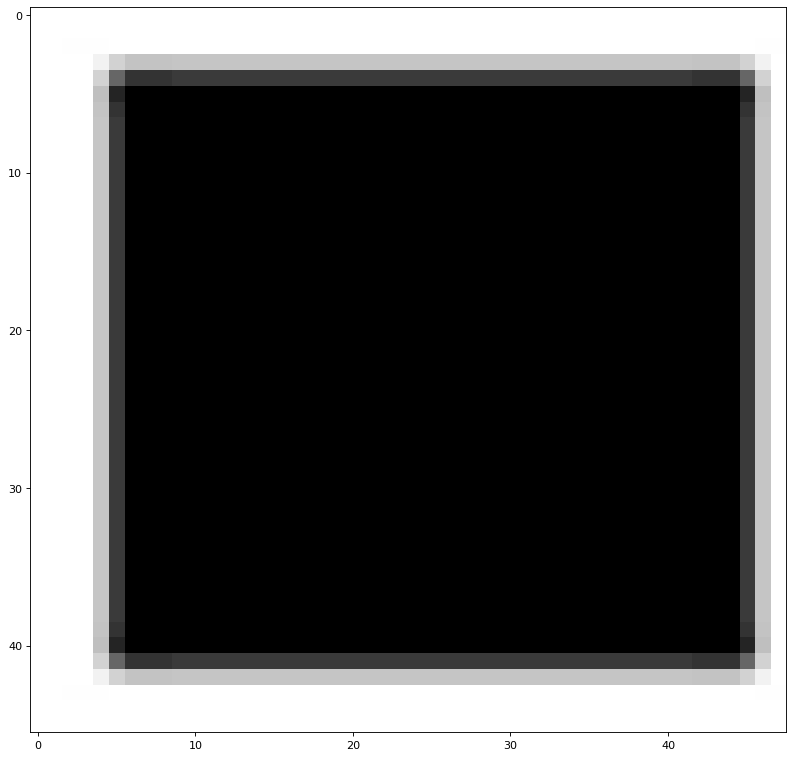

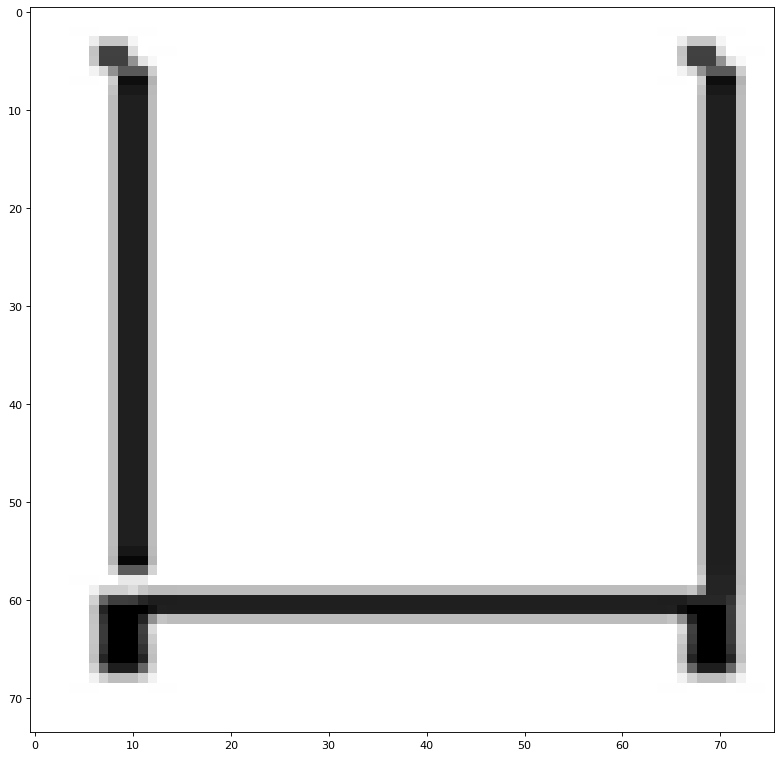

In [82]:
# from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer = []

for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner = ''
        if(len(finalboxes[i][j]) == 0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0], finalboxes[i][j][k][1], finalboxes[i][j][k][2], finalboxes[i][j][k][3]
                finalimg = bitnot[x : x + h, y : y + w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel, iterations=1)
                erosion = cv2.erode(dilation, kernel, iterations=2)
                plotImage(erosion)
                
                out = pytesseract.image_to_string(erosion)

                if(len(out) == 0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner + " " + out
            outer.append(inner)

In [ ]:
# Creating a dataframe of the generated OCR list
# arr = np.array(outer)
# dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
# display(dataframe)